# Segundo Projecto CRC 

## Imports

In [123]:
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from networkx.algorithms import community
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering
from networkx.drawing.nx_pydot import write_dot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
from networkx.algorithms import approximation as apxa
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelBinarizer
from mlxtend.frequent_patterns import apriori

## General Functions

In [46]:
warnings.filterwarnings('ignore')

def calculate_scores(y_test, y_pred, draw=False):
                     
    conf_matrix = confusion_matrix(y_test, y_pred)
        
    accuracy = (conf_matrix[0,0] + conf_matrix[1,1]) / sum(sum(conf_matrix))
    sensitivity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
    specificity = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])
    fscore = f1_score(y_test, y_pred, average='weighted')
    
    if draw:
        print('Accuracy    : ', accuracy) 
        print('Sensitivity : ', sensitivity) 
        print('Specificity : ', specificity) 
        print('Recall      : ', recall_score(y_test, y_pred, average='weighted')) 
        print('Precision   : ', precision_score(y_test, y_pred, average='weighted'))
        print('F1 score    : ', fscore) 

    return fscore


def use_knn(X_train, y_train, X_test, n=10):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
        
    model = knn.fit(X_train, y_train)
    return model.predict(X_test)

### Pre Process Functions

In [3]:
def handle_binary_column(df, att):
    label_encoder = LabelEncoder()
    #df[att] = label_encoder.fit_transform(df[att])
    return df


def handle_numeric_column(df, att):
    min_max_scaler = MinMaxScaler()
    df[att] = df[att].astype(float)
    df[att] = min_max_scaler.fit_transform(df[[att]])
    return df


def handle_na_column_mean(df, att):
    df[att] = pd.to_numeric(df[att], errors='ignore')
    mean_df = df[att].dropna().mean()
    df[att] = df[att].fillna(mean_df)
    return df


def handle_na_column_median(df, att):
    median = df[att].dropna().median()
    df[att] = df[att].fillna(median)
    return df


def handle_na_column_mode(df, att):
    mode = df[att].dropna().mode()[0]
    df[att] = df[att].fillna(mode)
    return df


def drop_column_na(df):
    return df.loc[:, df.isnull().mean() < 0.8]


def pre_process_data(df, handle_na, classes=[]):
    for att in df.columns:
        if df[att].isnull().sum().sum() != 0 and att not in classes:
            df = handle_na(df, att)
        if att not in classes:
            df = handle_numeric_column(df, att)
        if att == 'dx':
            df = handle_binary_column(df, att)
    return df


def pre_process(training, method):
    new_df = pre_process_data(training, method, classes=['subjectid', 'dx', 'sex', 'age'])

    return new_df


def pre_process_drop(training, method):
    new_df = pre_process_data(drop_column_na(training), method, classes=['subjectid', 'dx', 'sex', 'age'])

    return new_df


def find_best_method(data_set, draw=False):
    methods = {handle_na_column_median:'Handle Median', handle_na_column_mean:'Handle Mean', handle_na_column_mode:'Handle Mode'}
    labels = data_set['dx']
    
    for method, method_name in methods.items():
        
        data_set_new = pre_process_drop(data_set, method)
        data_set_new_drop = data_set_new.drop(['Unnamed: 0'], axis=1).drop(['subjectid'], axis=1).drop(['dx'], axis=1).drop(['sex'], axis=1).drop(['age'], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(data_set_new_drop, labels, train_size=0.7, random_state=42)
        y_predict = use_knn(X_train, y_train, X_test, 5)
       
        score = calculate_scores(y_test, y_predict)
        
        if draw:
            print("With " + method_name + " method " + "score of: ")
            print()
            print(score)


def get_percentage_missing(data_frame):
    
    num = data_frame.isnull().sum()
    den = len(data_frame)
    
    return round(num/den, 2)
    

### Find Best Parameters

In [66]:
df = pd.read_csv('joined_data.csv', sep="," ,error_bad_lines=False, low_memory=False)

drop_cols = []

for i, row in df.dtypes.iteritems():
    if row == object and i!= 'subjectid' and i!='dx' and i!='sex' and i!='age':
        drop_cols.append(i)

df_medic = df.drop(drop_cols, axis=1)
df_medic_0 = df_medic.copy()

#get_percentage_missing(df_medic_0)
#find_best_method(df_medic_0)

In [11]:
df_medic_mean = pre_process_drop(df_medic_0, handle_na_column_mean)
df_medic_mean.to_csv("processed_medic.csv")

## Build Adjacency Matrix Based on Similarity

In [4]:
medic_mean_drop = pd.read_csv('processed_medic.csv')

labels = medic_mean_drop['dx']
ids = medic_mean_drop['subjectid']
sex = medic_mean_drop['sex']
age = medic_mean_drop['age']

medic_mean_drop = medic_mean_drop.drop(['Unnamed: 0'], axis=1).drop(['subjectid'], axis=1).drop(['dx'], axis=1).drop(['sex'], axis=1).drop(['age'], axis=1)

## Find Besk K Features

In [83]:
def find_best_features(X, y, feature_range=range(5,300)):
    best, best_comp = 0, 0
    scores = []
    
    for comp in feature_range:
        X_new = SelectKBest(chi2, k=comp).fit_transform(X.copy(), y.copy())
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size=0.7, random_state=42)
        y_predict = use_knn(X_train, y_train, X_test, 5)
        score = calculate_scores(y_test, y_predict)
       
        if score > best:
            best_comp = comp
            best = score
            
        scores += [score]
        
    return best_comp, scores

In [100]:
best_comp, f_scores = find_best_features(medic_mean_drop, labels)
medic_mean_drop_new = SelectKBest(chi2, k=15).fit_transform(medic_mean_drop.copy(), labels.copy())

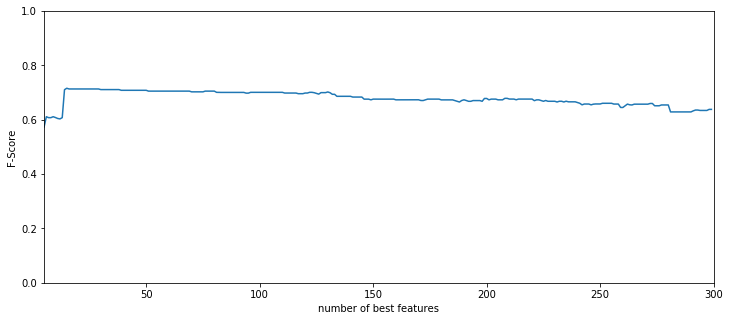

In [109]:
x_values_f = [x for x in range(5,300)]
plt.figure(figsize=(12, 5))
plt.ylim(0,1)
plt.xlim(5,300)
plt.xlabel("number of best features")
plt.ylabel("F-Score")
plt.plot(x_values_f, f_scores)
plt.savefig("best_features.png")

In [7]:
def build_adjacency_matrix(data_frame, distance_metric, threshold=2):
    
    distances = distance_metric(data_frame)
    size = len(distances)
    size_temp = 0
    temp_value = 0
    adj_matrix = np.zeros(shape=(size, size))
    
    for row in range(size):
        size_temp = len(distances[row])
        for value in range(size_temp):
            temp_value = distances[row][value]
            if temp_value > 0 and temp_value  <= threshold:
                adj_matrix[row][value] = 1
            else:
                continue
    return np.matrix(adj_matrix)

### Build Graph

In [8]:
def create_attributes(disorder, subjectID, age, gender):
    dis = {}
    s_id={}
    sx={}
    ag={}
    size = len(disorder)
    
    for i in range(size):
        s_id[i] = subjectID[i]
        dis[i] = disorder[i]
        sx[i] = gender[i]
        ag[i] = age[i]
    return s_id, dis, sx, ag

In [10]:
matrix = build_adjacency_matrix(medic_mean_drop_new, euclidean_distances, 0.1)

G = nx.from_numpy_matrix(matrix)
s_ids, disorders, sexs, ages = create_attributes(labels, ids, age, sex)

nx.set_node_attributes(G, 'subjectID', s_ids)
nx.set_node_attributes(G, 'disorder', disorders)
nx.set_node_attributes(G, 'age', ages)
nx.set_node_attributes(G, 'gender', sexs)

In [ ]:
write_dot(G, 'disorders.dot')

## Clustering

### Find best Number Of Clusters

In [59]:
def find_best_spectral(X, labels, max_k=22, draw=False):

    rand_scores, silhoute_scores = [], []
    for k in range(2, max_k):
        
        y_predict = SpectralClustering(n_clusters=k).fit_predict(X)
        rand_score = adjusted_rand_score(y_predict, labels)
        silhoute_score = silhouette_score(X, y_predict)
        
        if draw:
            print("{:18} -> {}".format("K", k))
            print("{:20}: {}".format("Rand Index", rand_score))
            print()

        rand_scores += [rand_score]
        silhoute_scores += [silhoute_score]
              
    return rand_scores

K                  -> 2
Rand Index          : 0.11458588569328187

K                  -> 3
Rand Index          : 0.11088642768622525

K                  -> 4
Rand Index          : 0.17318156298048748

K                  -> 5
Rand Index          : 0.1472378046633674

K                  -> 6
Rand Index          : 0.1414926640477697

K                  -> 7
Rand Index          : 0.12540716924133977

K                  -> 8
Rand Index          : 0.12982382836307796

K                  -> 9
Rand Index          : 0.10847567709211157

K                  -> 10
Rand Index          : 0.11040093233999894

K                  -> 11
Rand Index          : 0.10701378296174893

K                  -> 12
Rand Index          : 0.10996348597819237

K                  -> 13
Rand Index          : 0.1081384152373265

K                  -> 14
Rand Index          : 0.09969183324276233

K                  -> 15
Rand Index          : 0.0964563944533352

K                  -> 16
Rand Index          : 0.09981396942

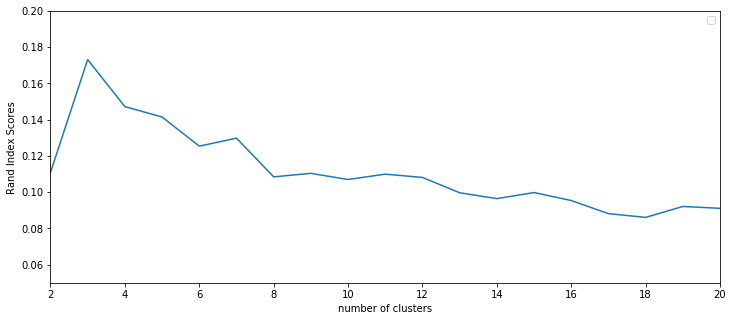

In [111]:
scores = []

scores = find_best_spectral(medic_mean_drop_new, labels, draw=True)

x_values = [x for x in range(1,21)]

plt.figure(figsize=(12, 5))
plt.ylim(0.05,0.2)
plt.xlim(2,20)
plt.xlabel("number of clusters")
plt.ylabel("Rand Index Scores")
plt.legend("Find Best Number Of Clusteres")
plt.plot(x_values, scores)
#plt.savefig("best_clusters.png")

Text(0.5,1,'Segregation of Clusters')

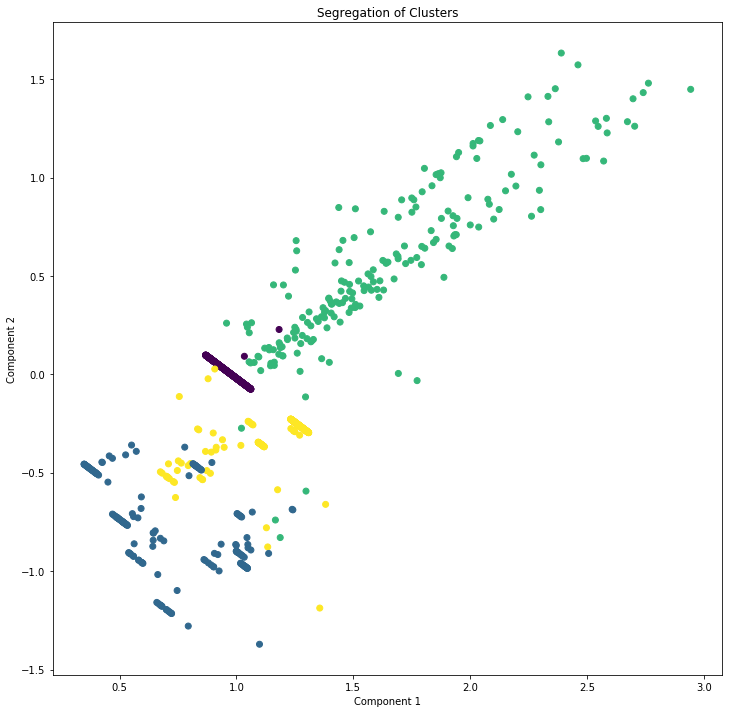

In [104]:
adj_mat = nx.to_numpy_matrix(G)

clusters = SpectralClustering(n_clusters=4, random_state=42, n_jobs=-1, n_init=1000).fit_predict(medic_mean_drop_new)

sc = SpectralClustering(4, affinity='precomputed',random_state=42, n_jobs=-1, n_init=1000).fit_predict(adj_mat)

svd_model = TruncatedSVD(n_components=2)  # 2 components

lda_output_svd = svd_model.fit_transform(medic_mean_drop_new)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]


plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
#plt.scatter(x, y, c=sc)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Clusters" )
#plt.savefig("spectral.png")

### Hierarchical Clustering

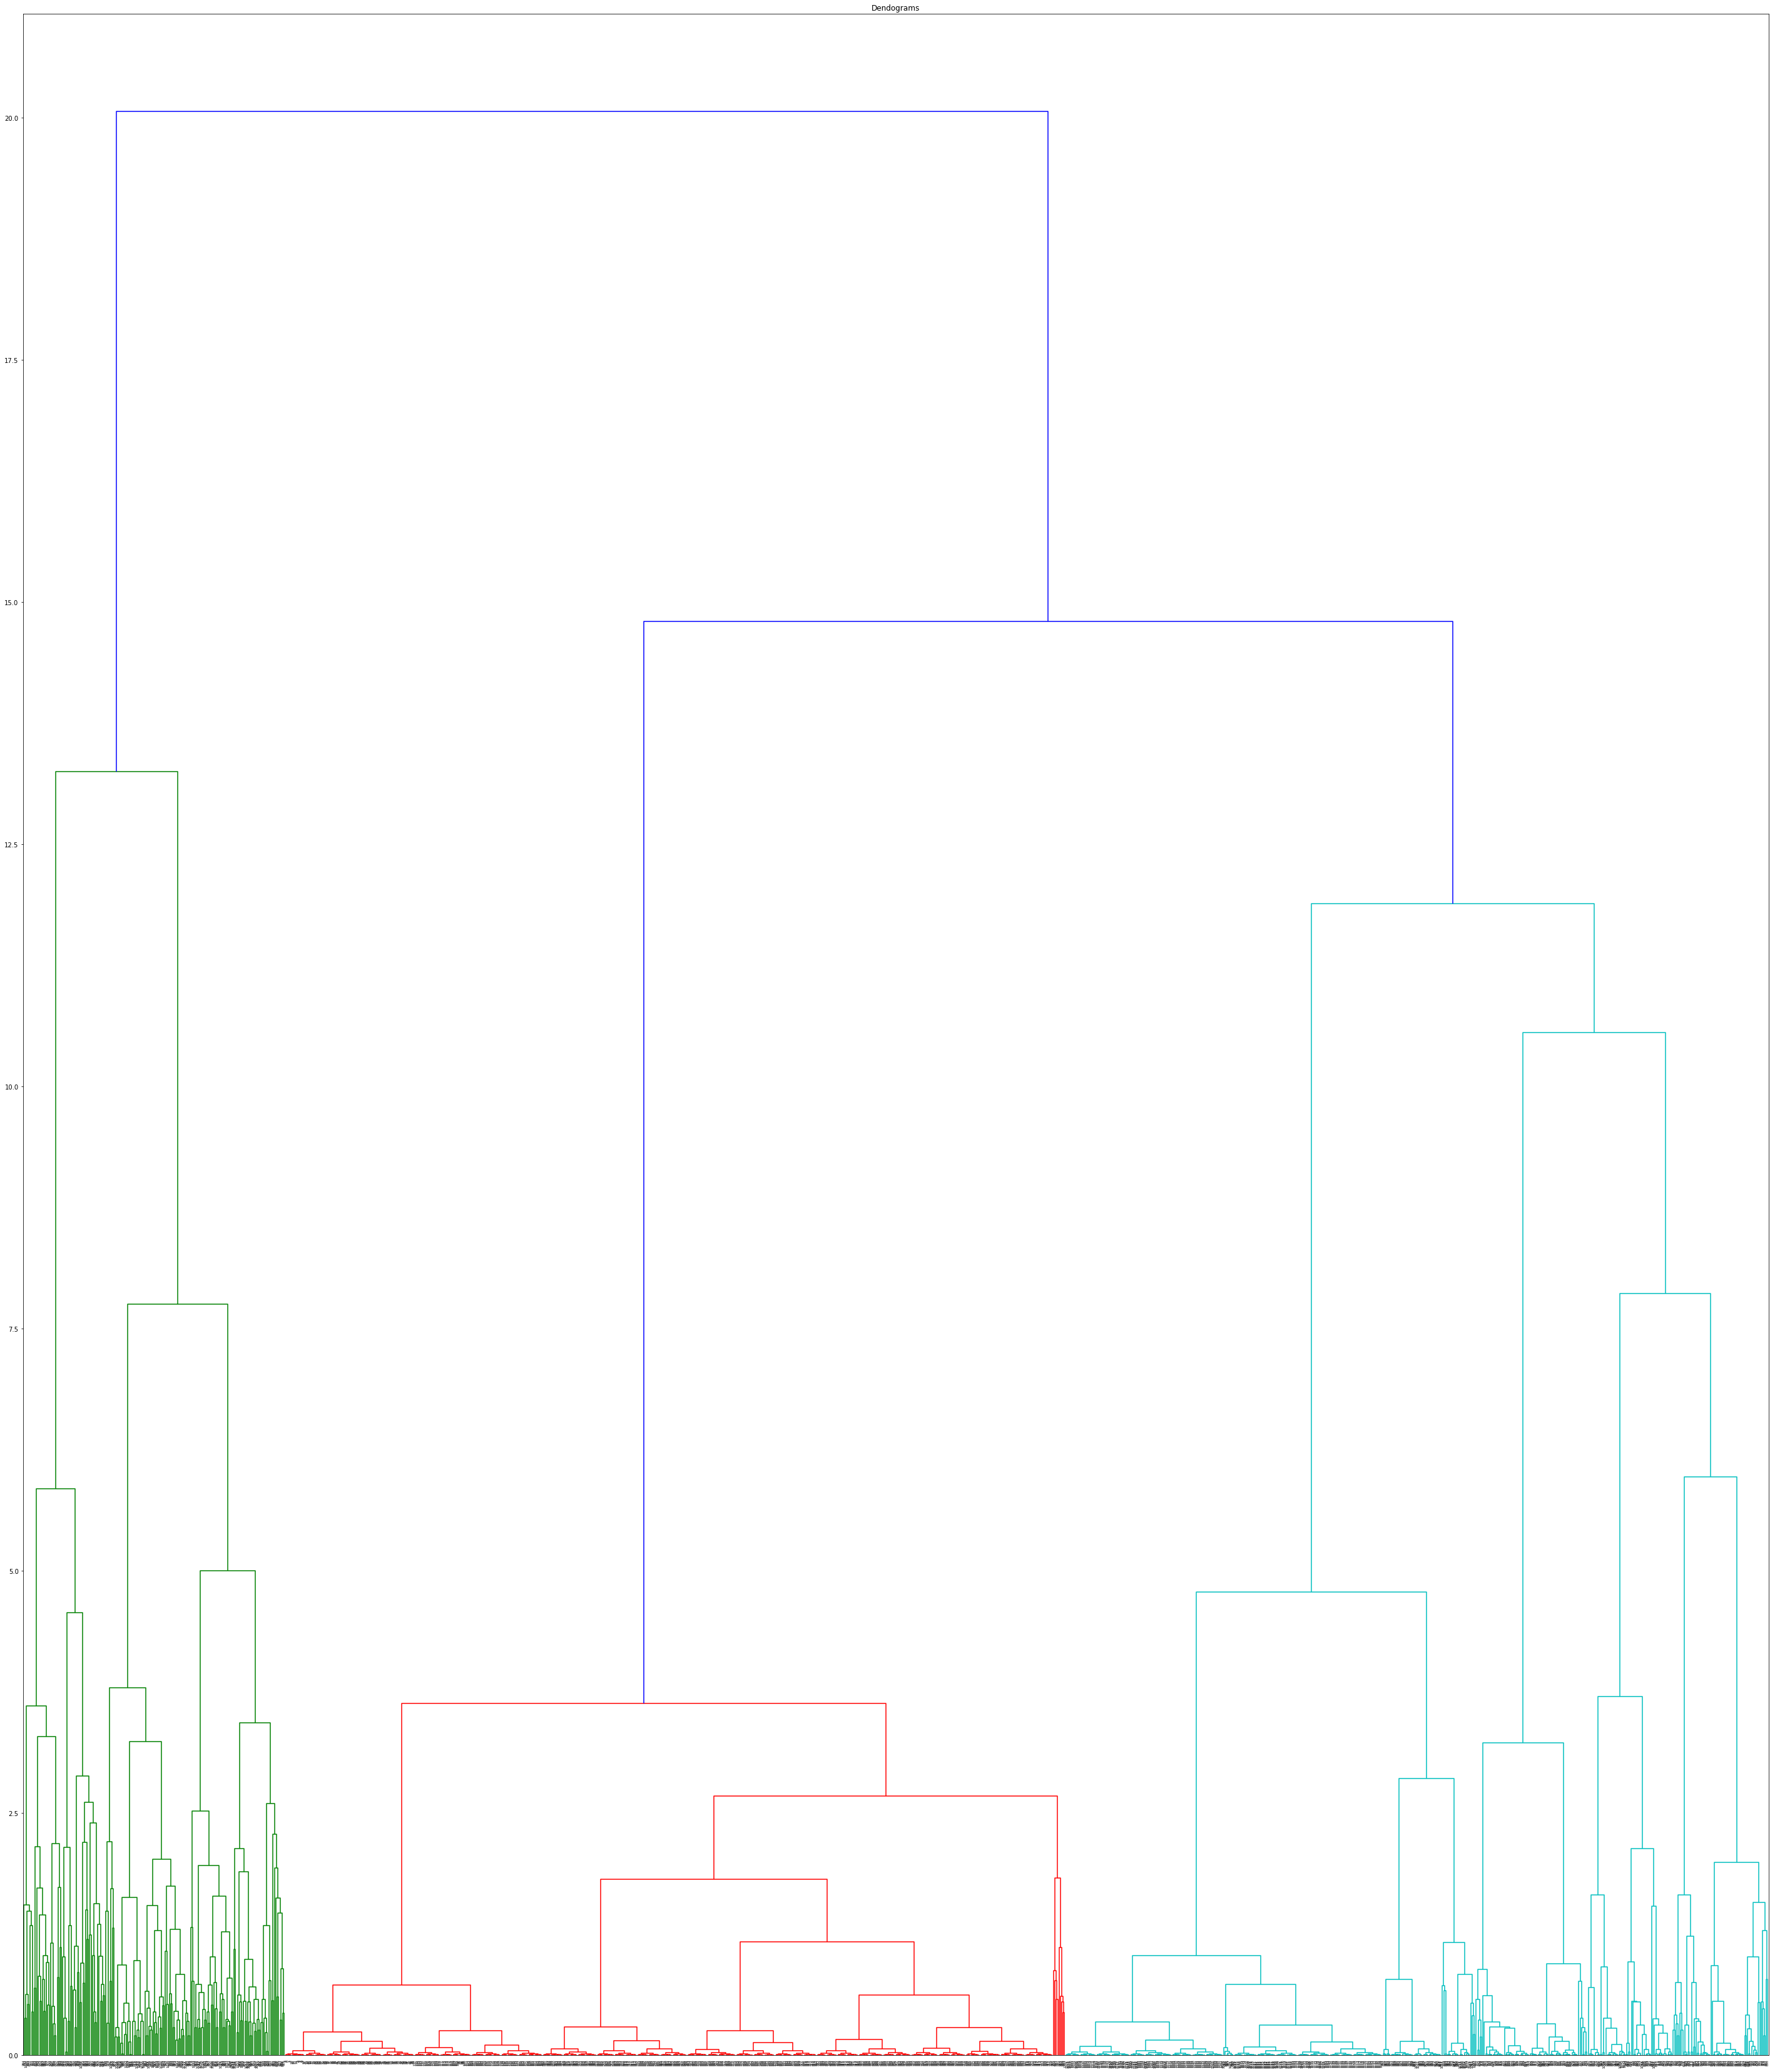

In [13]:
plt.figure(figsize=(50, 60))  
plt.title("Dendograms") 
dend = shc.dendrogram(shc.linkage(medic_mean_drop_new, method='ward'))
#plt.savefig("hierar.png")

## Patern Mining

### Dicretization

In [112]:
def equal_width_discretization(df, discrete=[], to_print=False):
    for col in list(df):
        if col not in discrete:
            df[col] = pd.cut(df[col], 10, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
            df[col] = df[col].replace(np.nan, 12).astype(int)
        attrs = []
        values = df[col].unique().tolist()
        values.sort()
        for val in values: attrs.append("%s:%s"%(col,val)) 
        lb = LabelBinarizer().fit_transform(df[col]) 
        if len(attrs)==2:
            v = list(map(lambda x: 1 - x, lb))
            lb = np.concatenate((lb,v),1)
        df2 = pd.DataFrame(data=lb, columns=attrs)

        try:
            df2 = df2.drop(columns=[col+ ":12"])
        except:
            pass
        
        df = df.drop(columns=[col])
        df = pd.concat([df,df2], axis=1, join='inner')
   
    if to_print:
        display(HTML(df.to_html(max_rows=10)))
            
    return df


def equal_frequency_discretization(df, discrete=[], to_print=False):
    for col in list(df):
        if col not in discrete:
            df[col] = pd.qcut(df[col], 4, duplicates='drop', labels=False)
            df[col] = df[col].replace(np.nan, 20).astype(int)
        attrs = []
        values = df[col].unique().tolist()
        values.sort()
        for val in values: attrs.append("%s:%s"%(col,val)) 
        lb = LabelBinarizer().fit_transform(df[col]) 
        if len(attrs)==2:
            v = list(map(lambda x: 1 - x, lb))
            lb = np.concatenate((lb,v),1)
        df2 = pd.DataFrame(data=lb, columns=attrs)
        
        try:
            df2 = df2.drop(columns=[col+ ":20"])
        except:
            pass
        
        df = df.drop(columns=[col])
        df = pd.concat([df,df2], axis=1, join='inner')
        
    if to_print:
        display(HTML(df.to_html()))
            
    return df

In [119]:
medic_mean_drop_freq = equal_frequency_discretization(medic_mean_drop)
medic_mean_drop_width = equal_width_discretization(medic_mean_drop)

In [121]:
def find_support_threshold(df, ranges=[1.0, 0.6, -0.1], to_print=True):
    size = len(df)
    frequent_items = []
    
    for sup in np.arange(ranges[0], ranges[1], ranges[2]):
        frequent_itemsets = apriori(df, min_support=sup, use_colnames=True, n_jobs=-1)
        frequent_items.append(len(frequent_itemsets))
    
        if to_print:
            print("{:10} : {:0.3f}".format("Support", sup))
            print("{:10} : {}".format("Items", len(frequent_itemsets)))
            print("")
            
    return frequent_items
        
        
def assoc_rules(df, sup, conf=0.9, to_print=True):
    frequent_itemsets = apriori(df, min_support=sup, use_colnames=True, n_jobs=-1) 
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)
    rules.drop(labels="conviction", axis=1, inplace=True)    
    rules.sort_values(by="leverage", ascending=False, inplace=True)
    if to_print:
        display(HTML(rules.to_html(max_rows=10)))
    return rules

In [ ]:
frequent_items = []
frequent_items =  [find_support_threshold(medic_mean_drop_width, [1.0, 0.97, -0.005])]

Support    : 1.000
Items      : 0

Support    : 0.995
Items      : 4

Support    : 0.990
Items      : 173

Support    : 0.985
Items      : 1090

Support    : 0.980
Items      : 3277

Support    : 0.975
Items      : 354259



In [ ]:
sup = [list(np.arange(1.0, 0.97, -0.005))]